# Modeling Resting-State in Epilepsy

***

**Epileptor** (Jirsa et al., 2014) is a neural mass model able to realistically reproduce temporal seizure dynamics, **Generic 2-dimensional Oscillator** (close to a Hopf Bifurcation; Sanz-Leon et al., 2015), on the other hand, is a modal approximation of the well-known FitzHugh-Nagumo model already used to retrieved resting-state networks (Spiegler et al., 2016). Since we want to study resting-state activity in epileptic brain, we propose to combine the two previous models together (Courtiol et al., 2018). The neural activity of each brain region is then given by the following equations:

\begin{eqnarray}
    \dot{x}_{1,i} &=& y_{1,i} - f_{1}(x_{1,i}, x_{2,i}) - z_{i} + I_{ext_{1}}\\
    \dot{y}_{1,i} &=& 1 - 5x_{1,i}^{2} - y_{1,i}\\
    \dot{z}_{i} &=& \dfrac{1}{\tau_{0}} \ (4 (x_{1,i} - x_{0,i}) - z_{i} - K_{s} \ \sum_{j=1}^{N}C_{ij}(x_{1,j} - x_{1,i}))\\
    \dot{x}_{2,i} &=& - y_{2,i} + x_{2,i} - x_{2,i}^{3} + I_{ext_{2}} + b_{2}.g(x_{1,i}) - 0.3 (z_{i} - 3.5)\\
    \dot{y}_{2,i} &=& \dfrac{1}{\tau_{2}} \ (-y_{2,i} + f_{2}(x_{2,i}))\\
    \dot{x}_{rs,i} &=& d \ (-x_{rs, i}^{2} + 3x_{rs, i}^{2} + y_{rs, i} + K_{rs} \ \sum_{j=1}^{N}C_{ij}(x_{rs,j} - x_{rs,i}))\\
    \dot{y}_{rs,i} &=& d \ (-10x_{rs, i} - y_{rs, i} + a_{i})\\
\end{eqnarray}

where $\tau_{0}=2857$, $I_{ext_{1}}=3.1$, $I_{ext_{2}}=0.45$ and $d=0.02$.

The degree of **epileptogenicity**
and **excitability** of each hybrid Epileptor is represented by the value $\pmb{x_{0, i}}$ and $\pmb{a_{i}}$, respectively. The characteristic time scale of population ($x_{2}, y_{2}$), $\pmb{\tau_{2}}$, and low-pass filtered excitatory coupling, $\pmb{b_{2}}$, are set at the origin at 10 and 1, respectively. $\pmb{C_{ij}}$ are the entries of the **anatomical structural connectivity matrix** reweigthed by the **global coupling** parameters: $\pmb{K_{s}}$ in the first population ($x_{1}, y_{1}$), and $\pmb{K_{rs}}$ in the third population ($x_{rs}, y_{rs}$).

The model can be directly related to a population’s average membrane potential (e.g., voltage-based models). The **LFP** is the directed sum of discharges: $\pmb{p \ (-x_{1} + x_{2}) + (1 - p)\ x_{rs}}$, with $0 < p < 1$.

### References:

> - (Jirsa et al., 2014) Jirsa, V. K.; Stacey, W. C.; Quilichini, P. P.; Ivanov, A. I.; Bernard, C. **On the nature of seizure dynamics.** Brain, 2014; 137: 2210–30.
> - (Sanz-Leon et al., 2015) Sanz-Leon, P., Knock, S. A., Spiegler, A., Jirsa, V. K. **Mathematical framework for large-scale brain network modeling in The
Virtual Brain.** NeuroImage, 2015; 111:385-430.
> - (Spiegler et al., 2016): Spiegler, A.;  Hansen, E.; Bernard, C.; McIntosh, A.R.; Jirsa, V.K. **Selective activation of resting-state networks following focal stimulation in a connectome-based network model of the human brain.** eNeuro, 2016; 0068-16.
> - (Courtiol et al., 2018) *in submission.*


## How to do it with TVB?

***

In the first part of this tutorial, we present the basic anatomy of a region based-simulation using The Virtual Brain's scripting interface.

The first thing we want to do is to import the modules we will need for a simulation.

In [49]:
%matplotlib inline

# Import a bunch of stuff to ease command line usage.
from tvb.simulator.lab import *
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
from tvb.datatypes.time_series import TimeSeriesRegion
import numpy as np
import time as tm
import matplotlib.pyplot as plt 
import sys

## 1. Region-based simulation in epilepsy during resting-state

## Setting up the simulation

- ### Connectivity

We start by loading and visualizing the **structural connectivity matrix** that represents the set of all existing anatomical connections between brain areas. Having loaded the default dataset, we can then alter the speed of signal propagation through the network.

2024-08-19 21:40:24,654 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


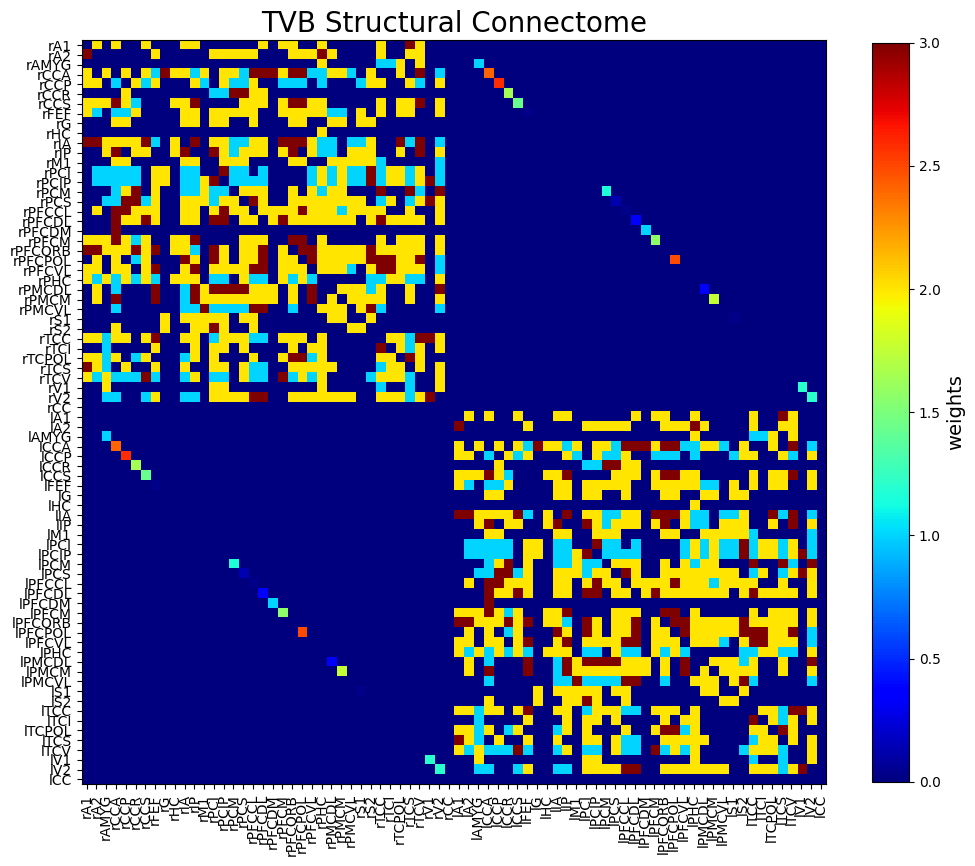

In [50]:
# Initialise the Connectivity.
con = connectivity.Connectivity.from_file('/Users/mac/Downloads/tvb_data/tvb_data/connectivity/connectivity_76.zip')      
nregions = len(con.region_labels)                               #number of regions
con.weights = con.weights - con.weights * np.eye((nregions))    #remove self-connection
con.speed = np.array([sys.float_info.max])                      #set conduction speed (here we neglect it)
con.configure()

# Visualization.
plt.figure(figsize=(12,12))
plt.imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
plt.title('TVB Structural Connectome', fontsize=20)
plt.xticks(range(0, nregions), con.region_labels, fontsize=10, rotation=90)
plt.yticks(range(0, nregions), con.region_labels, fontsize=10)
cb=plt.colorbar(shrink=0.8)
cb.set_label('weights', fontsize=14)
plt.show()

- ### Model

The **local neural (or Model) dynamics** of each brain area is a set of differential equations. There are a number of predefined models available in TVB. For our purpose here we will use the **hybrid version of Epileptor** that we defined above.

In the following, we will model a patient with a temporal lobe epilepsy (TLE).

In [51]:
# Initialise the Model.
mod = EpileptorRestingState(Ks=np.array([-0.1]), r=np.array([0.000015]), tau=np.array([1000]), K_rs=np.array([0.1]))
mod.a_rs = np.ones((nregions)) * (1.7402) 

We can refine the network pathology of the patient by including the hypothesis of the Epileptogenic Network. To this end, we define a **spatial map of epileptogenicity** where each network's node *i* is characterized by an excitability value $\pmb{x_{0,i}}$, which quantifies its ability to trigger a seizure. 

**We set:**
- the left limbic areas (left amygdala (lAMYG, region 40), hippocampus (lHC, region 47), and parahippocampus (lPHC, region 62)) as **Epileptogenic Zone (EZ)**, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to **-1.4** for the lAMYG and **-1.8** for the lHC and lPHC,
- we also add two lesser epileptogenic regions: the inferior temporal cortex (lTCI, region 69) and the ventral temporal cortex (lTCV, region 72) as **Propagation Zone (PZ)**, with lower epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to **-2.07** and **-2.08**, respectively,
- and all the other regions (or **Non Involved Zone, NIZ**) are set to **-2.15**.

In [52]:
# Heatmap of epileptogenicity and related parameters.
mod.x0 = np.ones((nregions)) * (-2.3)          #NIZ
mod.x0[[40]] = np.ones((1)) * (-1.4)           #EZ: lAMYG
mod.x0[[47, 62]] = np.ones((2)) * (-1.6)       #EZ: lHC, lPHC
mod.x0[[69]] = np.ones((1)) * (-1.7)           #PZ: lTCI
mod.x0[[72]] = np.ones((1)) * (-1.8)           #PZ: lTCV

mod.bb = np.ones((nregions)) * (4)             #NIZ
mod.bb[[40, 47, 62]] = np.ones((3)) * (1)      #EZ
mod.bb[[69, 72]] = np.ones((2)) * (2)          #PZ

mod.p = np.ones((nregions)) * (0.1)            #NIZ
mod.p[[40, 47, 62]] = np.ones((3)) * (0.9)     #EZ
mod.p[[69, 72]] = np.ones((2)) * (0.7)         #PZ

- ### Coupling function

It is a function that is used to join the local **Model** dynamics at distinct spatial locations over the connections described in **Connectivity**. Proper setting of the parameters for this function requires some knowledge of the properties of both the model being used and the structure through which it is connected. For our present purpose, we will use the **Difference coupling class** connected through TVB's default connectivity matrix.

Note that the global coupling parameter value for each submodel is already set in the initialisation of the model (see variables $K_{s}$ and $K_{rs}$ above), so here we set the value $coupl$ equal to 1.

In [53]:
# Initialise a Coupling function.
coupl = 1
con_coupling = coupling.Difference(a=np.array([coupl]))

- ### Integrator

Now that we have defined our structure and dynamics, we need to select an integration scheme. While TVB supports a number of schemes, for most purposes you should use either **HeunDeterministic** or **HeunStochastic**.

Note that the most important thing here is to use a step size that is small enough for the integration to be numerically stable.

**Additive white Gaussian noise** is introduced in the state-variables $\pmb{x_{2}}$ and $\pmb{y_{2}}$ with mean 0 and variance **0.00025**, and in the state-variable $\pmb{x_{rs}}$ with mean 0 and variance **0.001**. Other variables experience no noise due to their high sensitivity.

In [54]:
# Initialise an Integrator scheme.
dt = 0.1                  #integration steps [ms]
nsigma1 = 0.00025         #standard deviation of the noise
nsigma2 = 0.001

hiss = noise.Additive(nsig=np.array([0., 0., 0., nsigma1, nsigma1, 0., nsigma2, 0.]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

- ### Monitors

The last components we need to define are some Monitors. Although there are Monitors which apply a biophysical measurement process to the simulated neural activity, such as EEG, MEG, etc, here we will select one simple monitor just to show the idea:

- **TemporalAverage** monitor averages over a time window of length *period* returning one time point every *period* ms.

In [55]:
# Initialise some Monitors with period in physical time.
mon_tavg = monitors.TemporalAverage(period=1) #in ms  

# Bundle them
what_to_watch = (mon_tavg)


***

## Simulate

The last step is to bring all these components together into a **Simulator** object. We then need to run the configure method, which basically just acts to calculate information necessary for the simulation that draws on specific combinations of the components.

In [56]:
# Initialise the Simulator.
sim = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float64(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[what_to_watch])
sim.configure()

/var/folders/v7/dbllwbmn3qv0sk0spbzgpd440000gn/T/ipykernel_9843/746500494.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conduction_speed=np.float64(con.speed),


Now, we can run the simulation. The simulator that we have created is an iterable object, so all we need to do is iterate for some length, which we provide in *ms*, and collect the output:

In [57]:
# Perform simulation.
tic = tm.time()

tavg_time, tavg_data = [], []
for tavg in sim(simulation_length=60000):
    if not tavg is None:
        tavg_time.append(tavg[0][0])
        tavg_data.append(tavg[0][1])
    
'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 69.980 seconds.'


***

## Visualize our simulation

And finally, we can have a look at the results of our simulation in terms of time series.

The data returned by the simulator are in the form of a list of arrays. For most subsequent purposes it is much easier to deal with the data if they exist as a single contiguous array. And so we will do that now.

In [58]:
# Normalize time series
tavg_data /= (np.max(tavg_data, 0) - np.min(tavg_data, 0))
tavg_data -= np.mean(tavg_data, 0)

# Make lists numpy.arrays for easier use.  
TAVG = np.squeeze(np.array(tavg_data))
TAVG.shape

(60000, 3, 76)

As said above, the model can be directly related to the LFP by combining the 2 sub-models:

In [59]:
# Compute LFP output model.
DATA = mod.p[[0]] * TAVG[:, 0, :] + (1 - mod.p[[0]]) * TAVG[:, 2, :]

EZs = [62, 47, 40]
for ie, ez in enumerate(EZs):
    DATA[:, EZs[ie]] = mod.p[[EZs[ie]]] * TAVG[:, 0, EZs[ie]] + (1 - mod.p[[EZs[ie]]]) * TAVG[:, 2, EZs[ie]]
    
PZs = [69, 72]
for ip, pz in enumerate(PZs):
    DATA[:, PZs[ip]] = mod.p[[PZs[ip]]] * TAVG[:, 0, PZs[ip]] + (1 - mod.p[[PZs[ip]]]) * TAVG[:, 2, PZs[ip]]

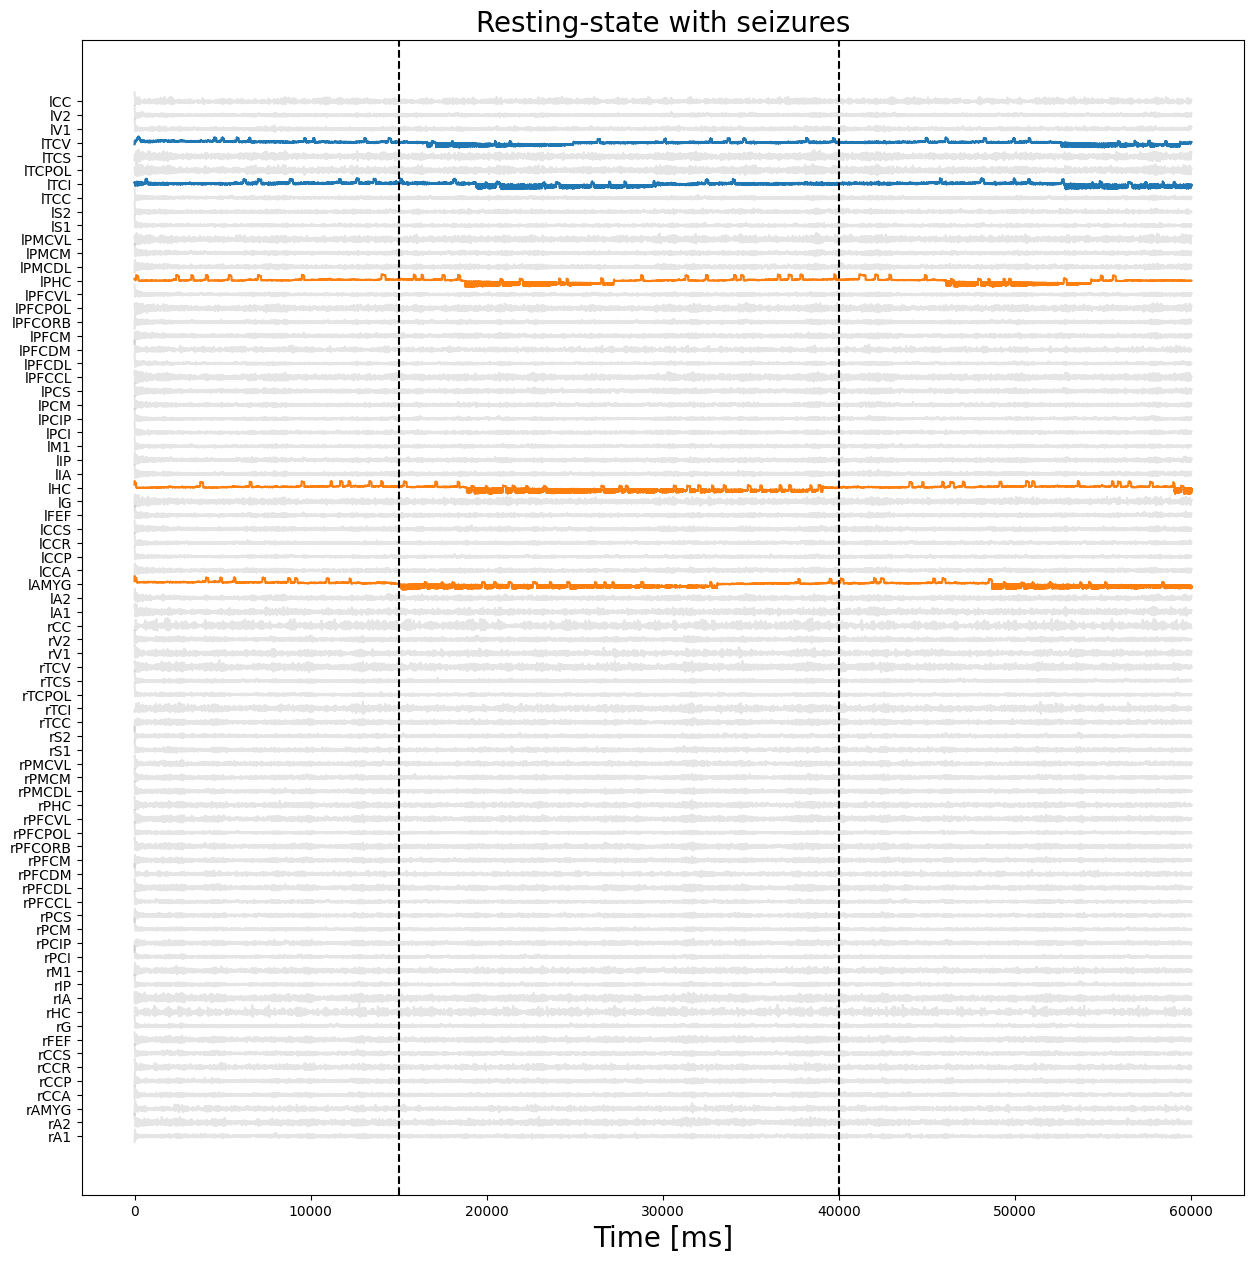

In [60]:
# Plot time series.
fig1 = plt.figure(figsize=(15,15))
plt.plot(DATA[:, :] + np.r_[:nregions], 'k', alpha=0.1)
plt.yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=10)

EZs = [62, 47, 40]
for ie, ez in enumerate(EZs):
    plt.plot(DATA[:, EZs[ie]] + EZs[ie], 'C1')
PZs = [69, 72]
for ip, pz in enumerate(PZs):
    plt.plot(DATA[:, PZs[ip]] + PZs[ip], 'C0')
    
plt.axvline(x=15000, color='k', linestyle='--')
plt.axvline(x=40000, color='k', linestyle='--')
    
plt.title('Resting-state with seizures', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)

plt.show()

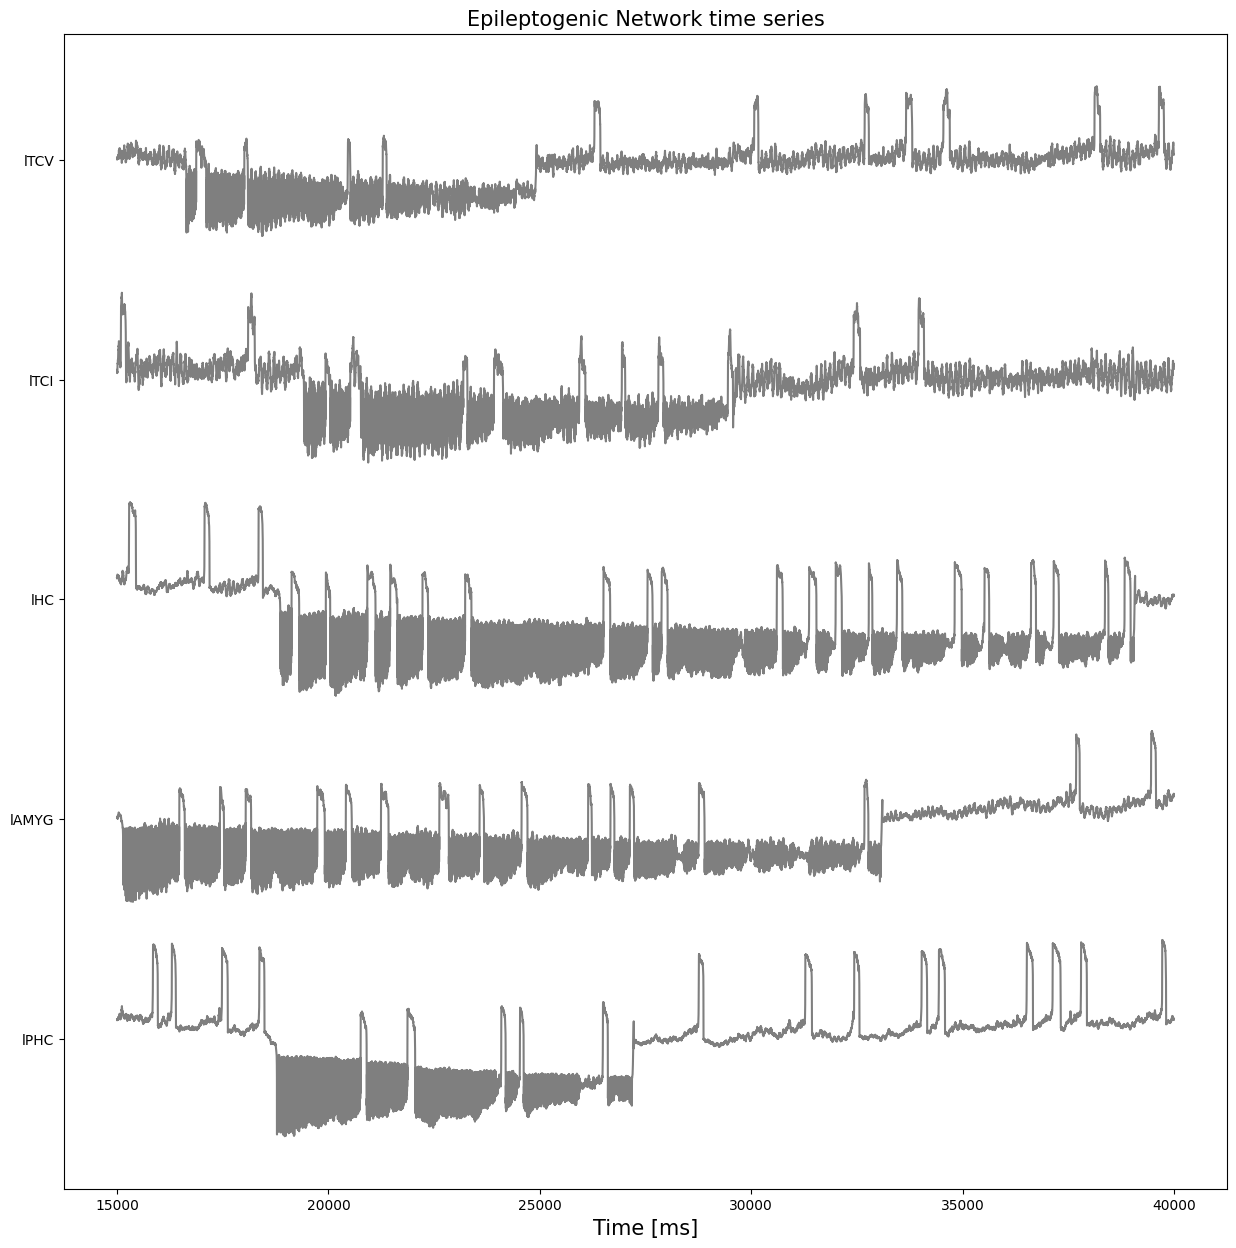

In [61]:
# Zoom.
EN = [62, 40, 47, 69, 72]
idx = np.arange(len(EN))

fig2 = plt.figure(figsize=(15,15))
for ie, en in enumerate(EN):
    plt.plot(np.arange(15000, 40000), DATA[15000:40000, EN[ie]] + idx[ie], 'k', alpha=0.5)
plt.title('Epileptogenic Network time series', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.yticks(np.arange(len(EN)), con.region_labels[EN])

plt.show()

## 2. Generation of use cases

When monitoring resting-state activity in epileptic patients, we can either observe **spontaneous epileptic discharges (i.e., ictal state)**, or **interictal discharges (i.e., interictal state)** or even **no abnormalities (i.e., spikes-free interictal state)** in the signal.


Therefore, we can generate 3 different scenari, namely:


- **Resting-state with seizures,**
- **Resting-state with interictal spikes,**
- **Resting-state without any epileptiform activity,**


and analyse them.  

## 2.1 Resting-State with Seizures

To investigate resting-state brain networks, we can use **Functional Connectivity (FC)** analysis.

FC describes the connectedness of two brain regions by means of the covariance between their time series. The classic and most widely used method to infer the strength of network interactions or functional connections consists in estimating the linear (Pearson) correlation coefficient between temporal signals. If two regions activate and deactivate at the same time, there is likely a functional connection. The Pearson correlation coefficient between two series $X$ and $Y$ of size $N$ is given by the following equation: 

\begin{eqnarray}
    Corr(X, Y) = \dfrac{\sum_{n=1}^{N}(X_{n} - \bar{X})(Y_{n} - \bar{Y})}{\sqrt{\sum_{n=1}^{N}(X_{n} - \bar{X})^2}\sqrt{\sum_{n=1}^{N}(Y_{n} - \bar{Y})^2}}
\end{eqnarray}

To this end, using the previously simulated time series, we will show how to build a **Region Time Series** object from our simulated data, and then apply a **Time Series Analyzer**, *corrcoef* in this case, to the time series, resulting in FC matrix.

So first, for the analyzer, we build a time series object from our previously simulated time series:

In [62]:
# Discarded first seconds to avoid initial transient dynamics and built 4D TVB matrix.
tvb_data = DATA[10000:50000, np.newaxis, :, np.newaxis]

# Built a TimeSeries Datatype.
tsr = TimeSeriesRegion(connectivity=con,
                       data=tvb_data, 
                       sample_period=sim.monitors[0].period)
tsr.configure()

Then we create and evaluate the analysis:

In [63]:
# Compute FC.
FCs = np.corrcoef(DATA[10000:50000].T)

Finally we can display the resulting FC matrix.

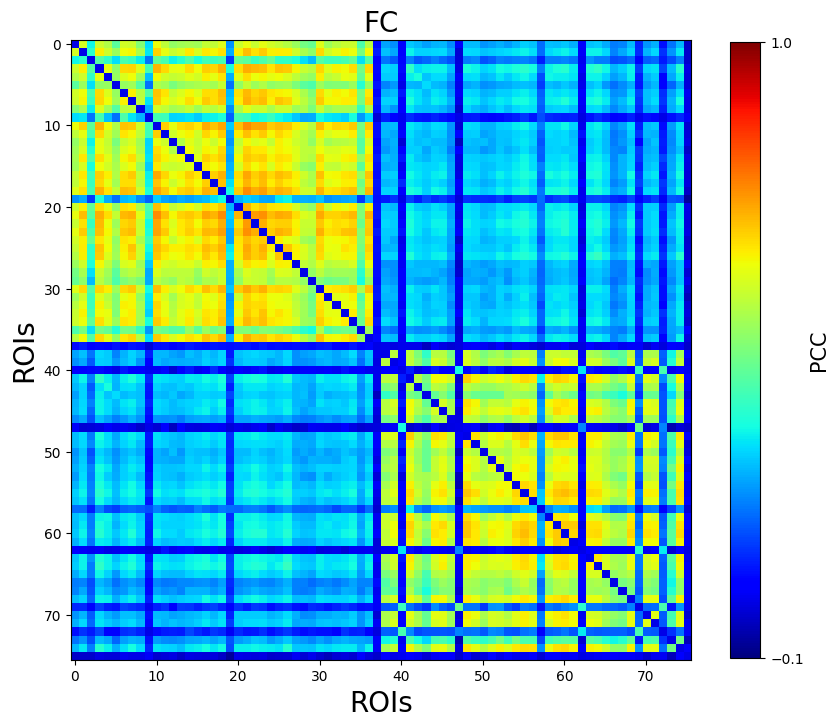

In [64]:
# Visualize FC.
plt.figure(figsize=(10,10))
plt.imshow(FCs - FCs * np.eye(nregions), interpolation='nearest', cmap='jet')
plt.title('FC', fontsize=20)
plt.xlabel('ROIs', fontsize=20); plt.ylabel('ROIs', fontsize=20)
cb=plt.colorbar(shrink=0.8, ticks=[-0.1, 1.])
cb.set_label('PCC', fontsize=15)
plt.clim([-0.1, 1.])
plt.show()

## 2.2 Resting-State with Interictal Spikes

In order to model resting-state activity with interictal spikes (ISs), we set the previously defined epileptogenic nodes (EZ and PZ) at the edge of the epileptogenic state, i.e.,  $\pmb{x_{0, NIZ} < x_{0, PZ} < x_{0, EZ} < x_{0, c}}$.

In [65]:
# Initialise Model.
mod = EpileptorRestingState(Ks=np.array([-0.1]), r=np.array([0.000015]), tau=np.array([1000]), K_rs=np.array([0.1]))
mod.a_rs = np.ones((nregions)) * (1.7402)

# Heatmap of epileptogenicity and related parameters.
mod.x0 = np.ones((nregions)) * (-2.3)           #NIZ
mod.x0[[40]] = np.ones((1)) * (-2.1)            #EZ: lAMYG
mod.x0[[47, 62]] = np.ones((2)) * (-2.135)      #EZ: lHC, lPHC
mod.x0[[69]] = np.ones((1)) * (-2.15)           #PZ: lTCI
mod.x0[[72]] = np.ones((1)) * (-2.15)           #PZ: lTCV

mod.bb = np.ones((nregions)) * (4)              #NIZ
mod.bb[[40, 47, 62]] = np.ones((3)) * (1)       #EZ
mod.bb[[69, 72]] = np.ones((2)) * (2)           #PZ

mod.p = np.ones((nregions)) * 0.1               #NIZ
mod.p[[40, 47, 62]] = np.ones((3)) * 0.9        #EZ
mod.p[[69, 72]] = np.ones((2)) * 0.7            #PZ

The rest of the model is set as before. We then build the simulator...

In [66]:
# Initialise Simulator.
sim = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float64(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[what_to_watch])
sim.configure()
sim

2024-08-19 21:41:37,796 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (8, 1, 1)


/var/folders/v7/dbllwbmn3qv0sk0spbzgpd440000gn/T/ipykernel_9843/3538204655.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conduction_speed=np.float64(con.speed),


...run the simulation...

In [67]:
# Perform simulation.
tic = tm.time()

tavg_time, tavg_data = [], []
for tavg in sim(simulation_length=50000):
    if not tavg is None:
        tavg_time.append(tavg[0][0])
        tavg_data.append(tavg[0][1])
    
'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 63.748 seconds.'

We normalize the results, then convert them in list of arrays...

In [68]:
# Normalize time series
tavg_data /= (np.max(tavg_data, 0) - np.min(tavg_data, 0))
tavg_data -= np.mean(tavg_data, 0)

# Make lists numpy.arrays for easier use.  
TAVG = np.squeeze(np.array(tavg_data))
TAVG.shape

(50000, 3, 76)

We export the LFP...

In [69]:
# Compute LFP output model.
DATA = mod.p[[0]] * TAVG[:, 0, :] + (1 - mod.p[[0]]) * TAVG[:, 2, :]

EZs = [62, 47, 40]
for ie, ez in enumerate(EZs):
    DATA[:, EZs[ie]] = mod.p[[EZs[ie]]] * TAVG[:, 0, EZs[ie]] + (1 - mod.p[[EZs[ie]]]) * TAVG[:, 2, EZs[ie]]
    
PZs = [69, 72]
for ip, pz in enumerate(PZs):
    DATA[:, PZs[ip]] = mod.p[[PZs[ip]]] * TAVG[:, 0, PZs[ip]] + (1 - mod.p[[PZs[ip]]]) * TAVG[:, 2, PZs[ip]]

... and visualize the results.

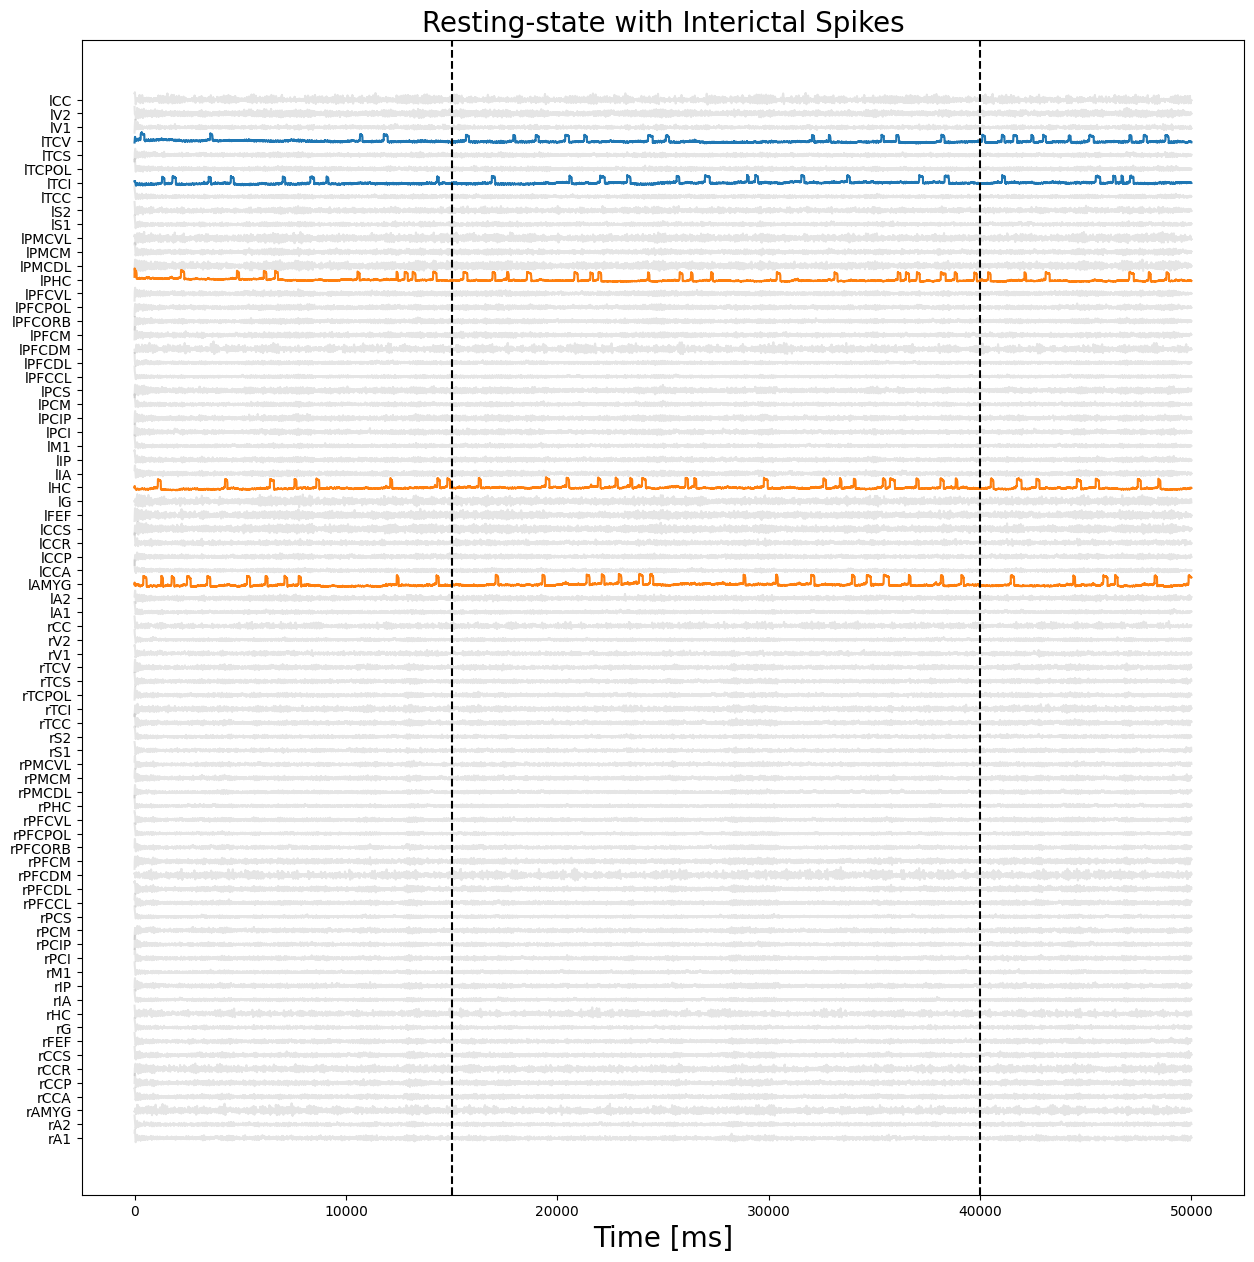

In [70]:
# Plot time series.
fig1 = plt.figure(figsize=(15,15))
plt.plot(DATA[:, :] + np.r_[:nregions], 'k', alpha=0.1)
plt.yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=10)

EZs = [62, 47, 40]
for ie, ez in enumerate(EZs):
    plt.plot(DATA[:, EZs[ie]] + EZs[ie], 'C1')
    #plt.yticks(np.arange(1), TVB_con.region_labels[ie])
PZs = [69, 72]
for ip, pz in enumerate(PZs):
    plt.plot(DATA[:, PZs[ip]] + PZs[ip], 'C0')
    
plt.axvline(x=15000, color='k', linestyle='--')
plt.axvline(x=40000, color='k', linestyle='--')
    
plt.title('Resting-state with Interictal Spikes', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)

plt.show()

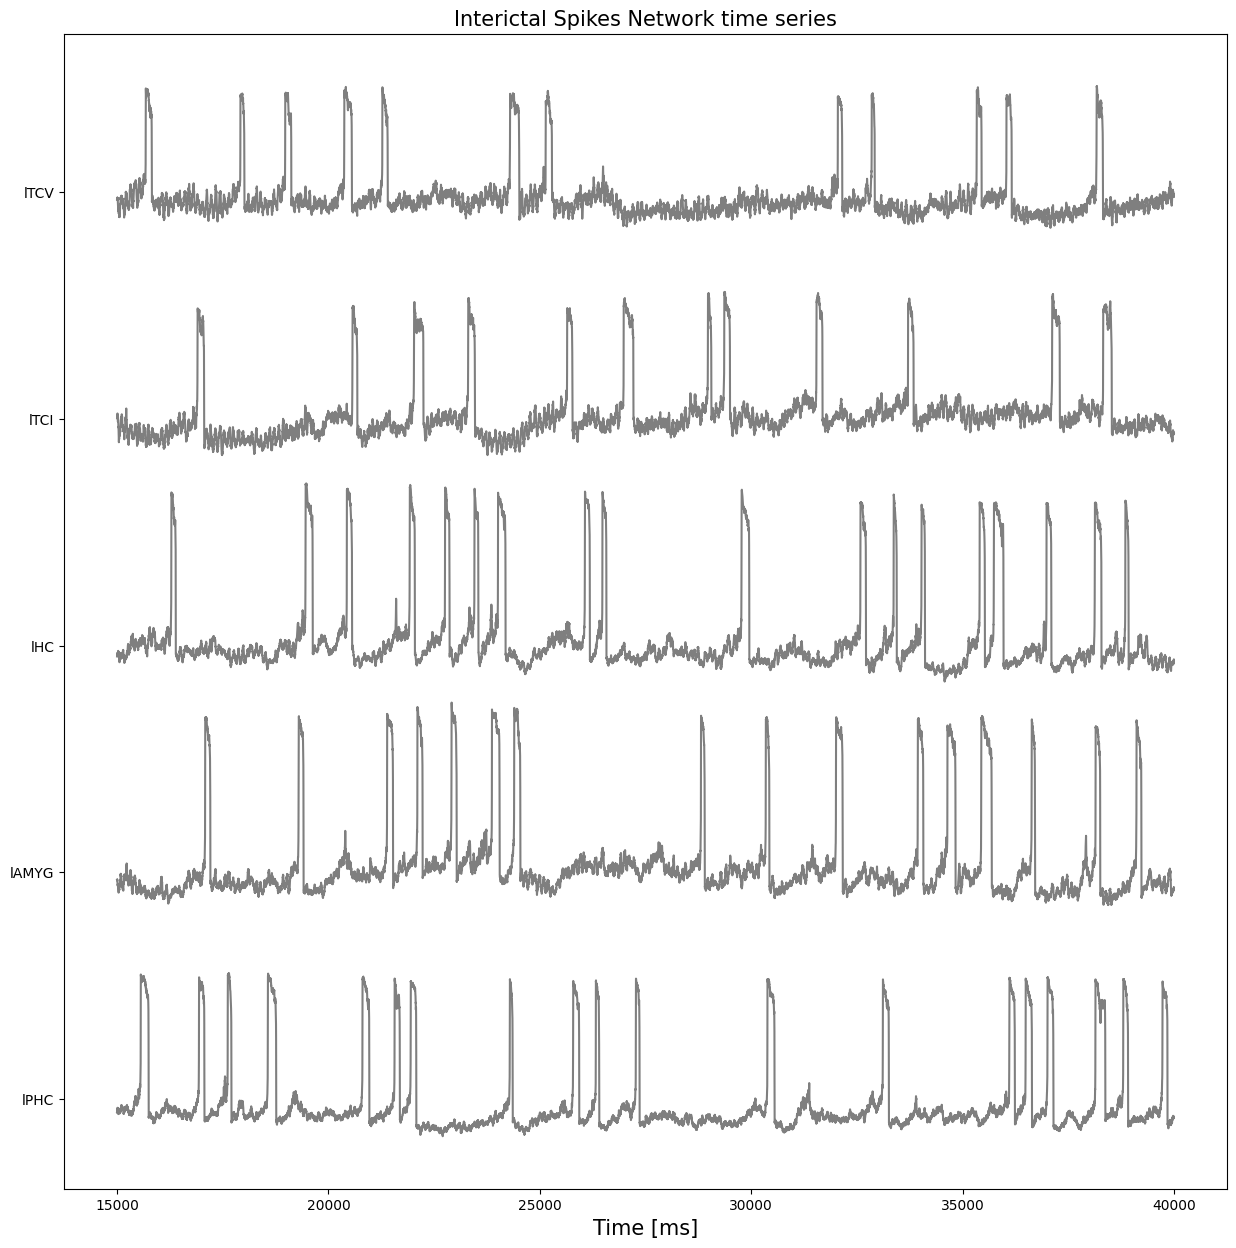

In [71]:
#Zoom.
ISN = [62, 40, 47, 69, 72]
idx = np.arange(len(EN))

fig2 = plt.figure(figsize=(15,15))
for ie, en in enumerate(ISN):
    plt.plot(np.arange(15000, 40000), DATA[15000:40000, ISN[ie]] + idx[ie], 'k', alpha=0.5)
plt.title('Interictal Spikes Network time series', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.yticks(np.arange(len(ISN)), con.region_labels[ISN])

plt.show()

We can now built the time series object and compute the FC.

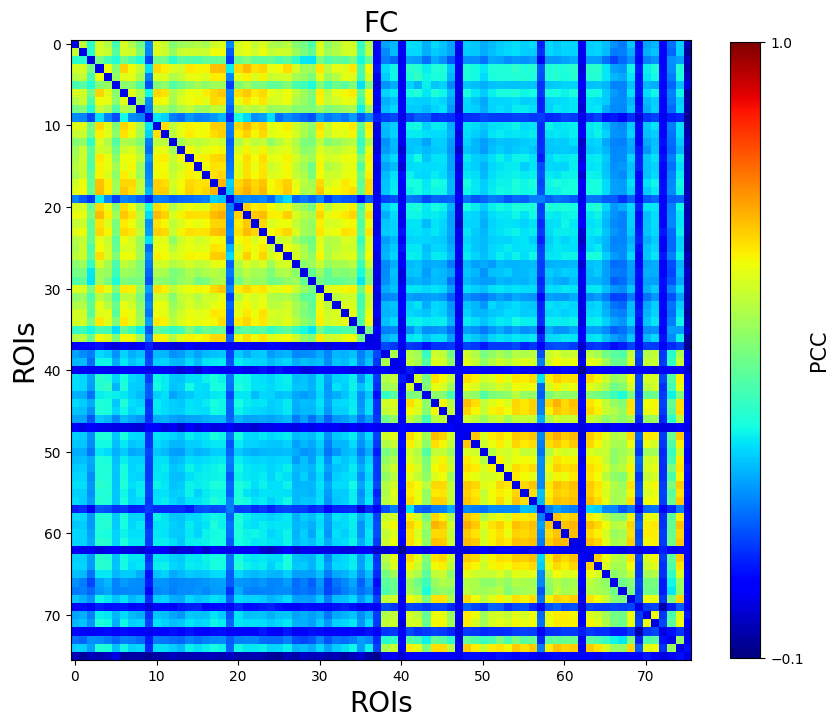

In [72]:
# Discarded first seconds to avoid initial transient dynamics.
FCiea = np.corrcoef(DATA[10000:50000].T)

# Visualize FC.
plt.figure(figsize=(10,10))
plt.imshow(FCiea-FCiea*np.eye(nregions), interpolation='nearest', cmap='jet')
plt.title('FC', fontsize=20)
plt.xlabel('ROIs', fontsize=20); plt.ylabel('ROIs', fontsize=20)
cb=plt.colorbar(shrink=0.8, ticks=[-0.1, 1.])
cb.set_label('PCC', fontsize=15)
plt.clim([-0.1, 1.])

plt.show()

## 2.3 Resting-State without Epileptiform Activity

In order to model resting-state without any epileptiform activity (EA), we set the Epileptor subsystem in a parameter space where only **normal state** exists (see Fig. 3.33 in El Houssaini, 2015), i.e., $\pmb{ x_{0,i} < -2.5}$ **for all node** $\pmb{i}$ as well as preventing any spike-and-wave events, i.e., $\pmb{b_{2} = 4}$.

In [73]:
# Initialise Model.
mod = EpileptorRestingState(Ks=np.array([-0.1]), K_rs=np.array([0.1]))

mod.a_rs = np.ones((nregions)) * (1.7402)
mod.x0 = np.ones((nregions)) * (-2.5)           
mod.bb = np.ones((nregions)) * (4)                   
mod.p = np.ones((nregions)) * (0.1)       

We can now configure the simulator by setting the rest of the model as before...

In [74]:
# Initialise Simulator.
sim = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float64(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[what_to_watch])
sim.configure()

2024-08-19 21:42:45,011 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (8, 1, 1)


/var/folders/v7/dbllwbmn3qv0sk0spbzgpd440000gn/T/ipykernel_9843/845221928.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conduction_speed=np.float64(con.speed),


... and lunch it.

In [75]:
# Perform simulation.
tic = tm.time()

tavg_time, tavg_data = [], []
for tavg in sim(simulation_length=50000):
    if not tavg is None:
        tavg_time.append(tavg[0][0])
        tavg_data.append(tavg[0][1])
    
'simulation required %0.3f seconds.' % (tm.time()-tic)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/simulator/history.py:204: RuntimeWarning: overflow encountered in cast
  self.buffer[step % self.n_time] = new_state[self.cvars]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/simulator/coupling.py:483: RuntimeWarning: invalid value encountered in subtract
  return x_j - x_i
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: invalid value encountered in _numba_dfun
  return self.ufunc(*args, **kwargs)


'simulation required 65.194 seconds.'

We convert the results in a format of list of arrays and compute the LFP...

In [76]:
# Normalize time series.
tavg_data /= (np.max(tavg_data, 0) - np.min(tavg_data, 0))
tavg_data -= np.mean(tavg_data, 0)

# Make the lists numpy.arrays for easier use.  
TAVG = np.squeeze(np.array(tavg_data))
TAVG.shape

# Compute LFP output model.
DATA = mod.p[[0]] * TAVG[:, 0, :] + (1 - mod.p[[0]]) * TAVG[:, 2, :]

... and plot the results.

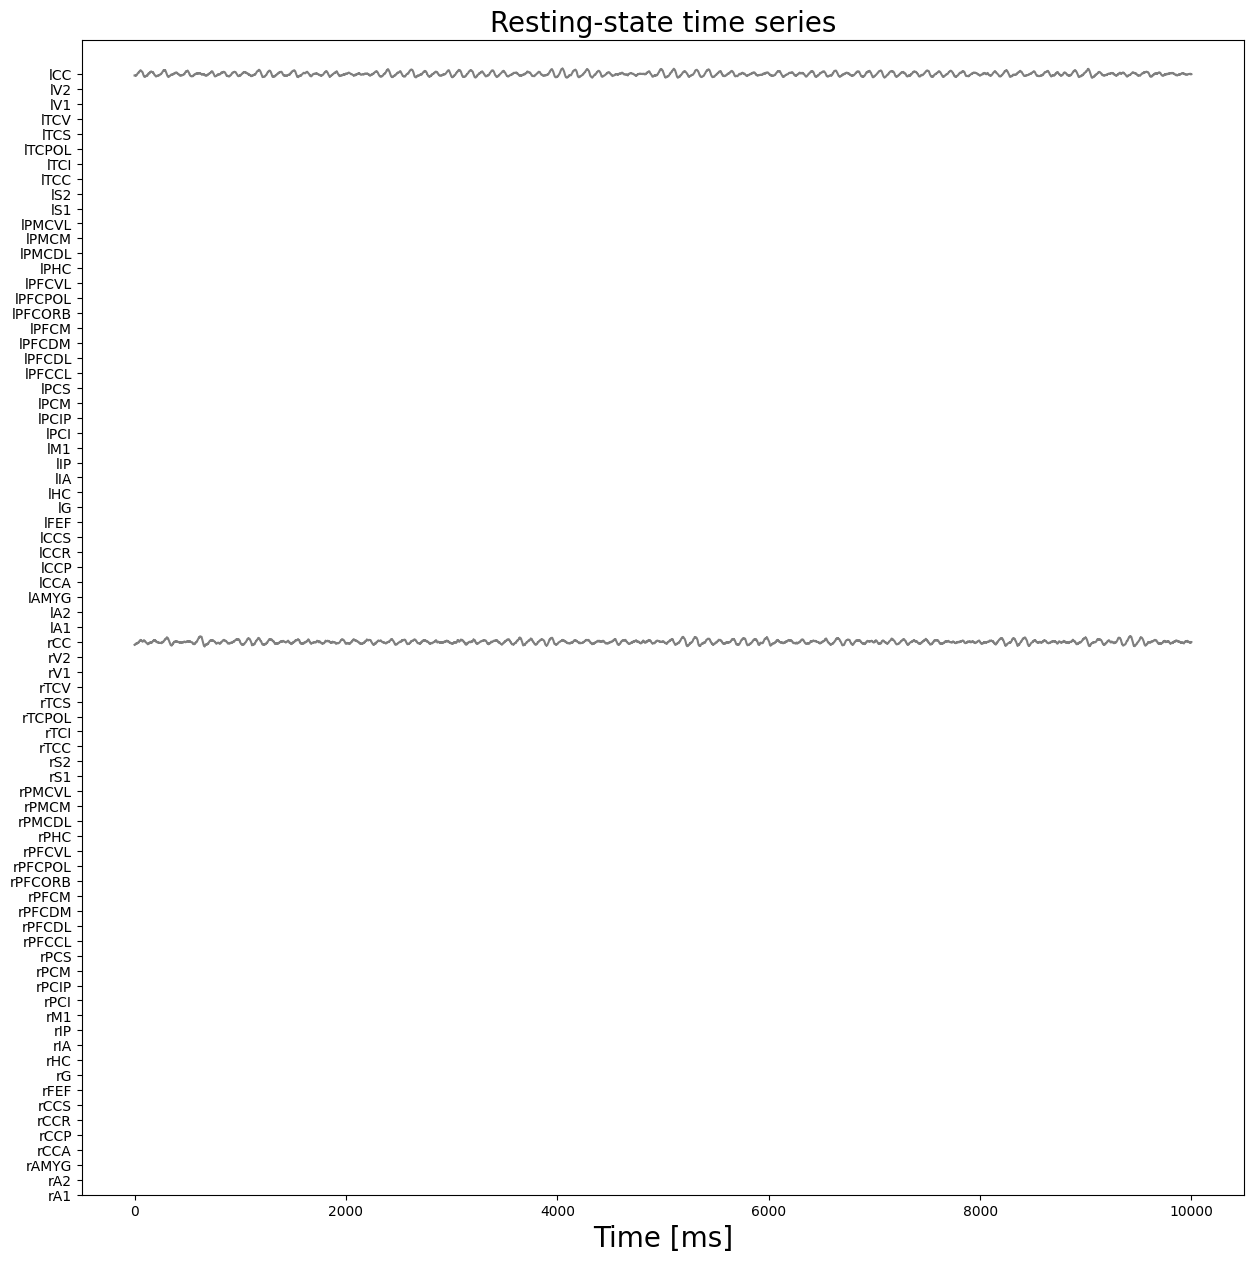

In [77]:
# Plot time series.
fig1 = plt.figure(figsize=(15,15))
plt.plot(DATA[10000:20000, :] + np.r_[:nregions], 'k', alpha=0.5)
plt.title('Resting-state time series', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=10)
plt.show()

We are building now again the time series object and computing the FC.

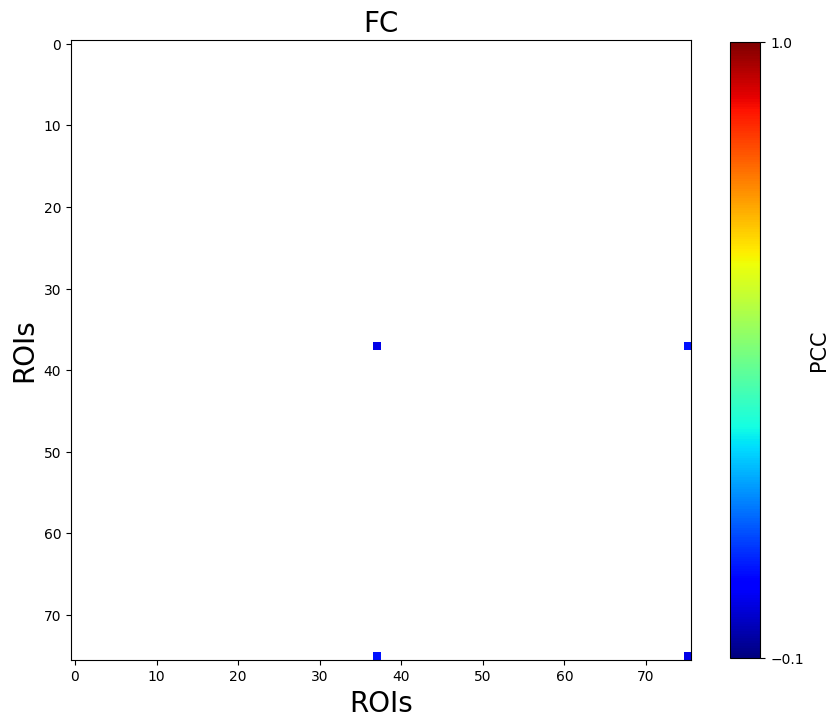

In [78]:
# Discarded first seconds to avoid initial transient dynamics.
FCrs = np.corrcoef(DATA[10000:50000].T)

# Visualize FC.
plt.figure(figsize=(10,10))
plt.imshow(FCrs-FCrs*np.eye(nregions), interpolation='nearest', cmap='jet')
plt.title('FC', fontsize=20)
plt.xlabel('ROIs', fontsize=20); plt.ylabel('ROIs', fontsize=20)
cb=plt.colorbar(shrink=0.8, ticks=[-0.1, 1.])
cb.set_label('PCC', fontsize=15)
plt.clim([-0.1, 1.])
plt.show()